In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)


In [2]:
from keras.layers.convolutional import Conv2D
from keras.layers import Input, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization, Concatenate, Activation, Dropout
from keras.optimizers import Adam
from keras import initializers
from keras.models import Model
from keras import backend as K
from dataGenerator import gen_train_data, test_data
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [3]:
path_weight = 'model_weight.h5'

In [3]:
# accuracy and loss
def iu_acc(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    smooth = 1e-12
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[1, 2, 3], keepdims=False)
    sum_ = K.sum(y_true + y_pred_pos, axis=[1, 2, 3], keepdims=False)
    jac = (intersection) / (sum_ - intersection + smooth)
    return K.mean(jac)

def dice_acc(y_true, y_pred):
    smooth = 1e-12
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[1, 2, 3], keepdims=False)
    sum_ = K.sum(y_true + y_pred_pos, axis=[1, 2, 3], keepdims=False)
    jac = (2*intersection + smooth) / (sum_ + smooth)
    return K.mean(jac)

# loss function
def my_loss(y_true,y_pred):
    bc = K.binary_crossentropy(y_pred, y_true)
    false_bc = (1.0 - y_true) * bc
    true_bc = y_true * bc
    mloss = false_bc + 10.0 * true_bc
    return mloss

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# dice_coef may have better performance
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def ConvActive(np_ker, size, inputs, 
                        initial = initializers.glorot_normal(seed=None)):
    
    return Conv2D(np_ker, size, activation='relu',padding = 'same', kernel_initializer = initial)(inputs)

def ConvBatchnormActive(np_ker, size, inputs, 
                        initial = initializers.glorot_normal(seed=None)):
    
    return Activation('relu')(BatchNormalization()(Conv2D(np_ker, size,padding = 'same', kernel_initializer = initial)(inputs)))

def UpConvActiveContact(np_ker, size, inputs, contact,
                  initial = initializers.glorot_normal(seed=None)):
    up = UpSampling2D(size = (2,2))(inputs)
    upconv = Conv2D(np_ker, size, activation = 'relu', padding = 'same', kernel_initializer = initial)(up) 
    return Concatenate(axis=3)([upconv, contact])

def get_unet(pretrained_weights = None):
    
    inputs = Input((512, 512, 3))

    conv1 = ConvBatchnormActive(16, 3, inputs)
    conv1 = ConvBatchnormActive(16, 3, conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)
    
    conv2 = ConvBatchnormActive(32, 3, pool1)
    conv2 = ConvBatchnormActive(32, 3, conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)
    
    conv3 = ConvBatchnormActive(64, 3, pool2)
    conv3 = ConvBatchnormActive(64, 3, conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)
    
    conv4 = ConvBatchnormActive(128, 3, pool3)
    conv4 = ConvBatchnormActive(128, 3, conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)
    
    conv5 = ConvBatchnormActive(256, 3, pool4)
    conv5 = ConvBatchnormActive(256, 3, conv5)
    
    up6 = UpConvActiveContact(128, 2, conv5, conv4)
    up6 = Dropout(0.5)(up6)
    conv6 = ConvBatchnormActive(128, 3, up6)
    conv6 = ConvBatchnormActive(128, 3, conv6)
    
    up7 = UpConvActiveContact(64, 2, conv6, conv3)
    up7 = Dropout(0.5)(up7)
    conv7 = ConvBatchnormActive(64, 3, up7)
    conv7 = ConvBatchnormActive(64, 3, conv7)
    
    up8 = UpConvActiveContact(32, 2, conv7, conv2)
    up8 = Dropout(0.5)(up8)
    conv8 = ConvBatchnormActive(32, 3, up8)
    conv8 = ConvBatchnormActive(32, 3, conv8)
    
    up9 = UpConvActiveContact(16, 2, conv8, conv1)
    up9 = Dropout(0.5)(up9)
    conv9 = ConvBatchnormActive(16, 3, up9)
    conv9 = ConvBatchnormActive(16, 3, conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [iu_acc, dice_acc, 'accuracy'])

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model



In [4]:
model = get_unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [5]:
#%% training from scratch

model_checkpoint = ModelCheckpoint('D:/Anil/saved_model/UNet/UNET_Gray_mold_50epoch_10000_it.hdf5', monitor = 'loss', verbose = 1, save_best_only =True)
callback_checkpoint = [model_checkpoint]

model = get_unet()
train_data = gen_train_data()
test_data = test_data()
history = model.fit_generator(train_data, steps_per_epoch=10000, epochs=50, verbose=1, 
                    shuffle=True, validation_data=test_data, callbacks = callback_checkpoint)



Epoch 1/50
Found 90 images belonging to 1 classes.
Found 90 images belonging to 1 classes.
10000/10000 [==============================] - 1241s 124ms/step - loss: -0.8069 - iu_acc: 0.8314 - dice_acc: 0.8952 - accuracy: 0.9939 - val_loss: -0.9611 - val_iu_acc: 0.8694 - val_dice_acc: 0.9206 - val_accuracy: 0.9973

Epoch 00001: loss improved from inf to -0.80692, saving model to D:/Anil/saved_model/UNet/UNET_Gray_mold_50epoch_10000_it.hdf5
Epoch 2/50
10000/10000 [==============================] - 1236s 124ms/step - loss: -0.9539 - iu_acc: 0.8917 - dice_acc: 0.9408 - accuracy: 0.9976 - val_loss: -0.9533 - val_iu_acc: 0.8785 - val_dice_acc: 0.9334 - val_accuracy: 0.9966

Epoch 00002: loss improved from -0.80692 to -0.95386, saving model to D:/Anil/saved_model/UNet/UNET_Gray_mold_50epoch_10000_it.hdf5
Epoch 3/50
10000/10000 [==============================] - 1236s 124ms/step - loss: -0.9575 - iu_acc: 0.8979 - dice_acc: 0.9442 - accuracy: 0.9977 - val_loss: -0.9404 - val_iu_acc: 0.8764 - val_

10000/10000 [==============================] - 1222s 122ms/step - loss: -0.9781 - iu_acc: 0.9424 - dice_acc: 0.9712 - accuracy: 0.9988 - val_loss: -0.9476 - val_iu_acc: 0.8621 - val_dice_acc: 0.9222 - val_accuracy: 0.9961

Epoch 00046: loss improved from -0.97786 to -0.97806, saving model to D:/Anil/saved_model/UNet/UNET_Gray_mold_50epoch_10000_it.hdf5
Epoch 47/50
10000/10000 [==============================] - 1221s 122ms/step - loss: -0.9779 - iu_acc: 0.9412 - dice_acc: 0.9707 - accuracy: 0.9988 - val_loss: -0.9354 - val_iu_acc: 0.8519 - val_dice_acc: 0.9142 - val_accuracy: 0.9952

Epoch 00047: loss did not improve from -0.97806
Epoch 48/50
10000/10000 [==============================] - 1221s 122ms/step - loss: -0.9782 - iu_acc: 0.9423 - dice_acc: 0.9710 - accuracy: 0.9988 - val_loss: -0.9657 - val_iu_acc: 0.8839 - val_dice_acc: 0.9322 - val_accuracy: 0.9973

Epoch 00048: loss improved from -0.97806 to -0.97822, saving model to D:/Anil/saved_model/UNet/UNET_Gray_mold_50epoch_10000_it.

In [ ]:
model = get_unet(path_weight)
model.summary()

In [5]:
#%% continue to train from weight

model_checkpoint = ModelCheckpoint('D:/Anil/saved_model/UNet/UNET_pretrained_Gray_mold_80epochs.hdf5', monitor = 'loss', verbose = 1, save_best_only =True)
callback_checkpoint = [model_checkpoint]

# model = get_unet(path_weight)

train_data = gen_train_data()
test_data = test_data()
history = model.fit_generator(train_data, steps_per_epoch=5000, epochs=80, verbose=1, 
                    shuffle=True, validation_data=test_data, callbacks = callback_checkpoint)


Epoch 1/80
Found 42 images belonging to 1 classes.
Found 42 images belonging to 1 classes.
5000/5000 [==============================] - 621s 124ms/step - loss: -0.6828 - iu_acc: 0.6783 - dice_acc: 0.7996 - accuracy: 0.9673 - val_loss: -0.6696 - val_iu_acc: 0.5194 - val_dice_acc: 0.6675 - val_accuracy: 0.9645

Epoch 00001: loss improved from inf to -0.68279, saving model to D:/Anil/saved_model/UNet/UNET_pretrained_Gray_mold_80epochs.hdf5
Epoch 2/80
5000/5000 [==============================] - 615s 123ms/step - loss: -0.8623 - iu_acc: 0.7660 - dice_acc: 0.8663 - accuracy: 0.9819 - val_loss: -0.6930 - val_iu_acc: 0.5335 - val_dice_acc: 0.6792 - val_accuracy: 0.9664

Epoch 00002: loss improved from -0.68279 to -0.86225, saving model to D:/Anil/saved_model/UNet/UNET_pretrained_Gray_mold_80epochs.hdf5
Epoch 3/80
5000/5000 [==============================] - 615s 123ms/step - loss: -0.8796 - iu_acc: 0.7837 - dice_acc: 0.8776 - accuracy: 0.9835 - val_loss: -0.7305 - val_iu_acc: 0.5684 - val_dic

5000/5000 [==============================] - 609s 122ms/step - loss: -0.9314 - iu_acc: 0.8684 - dice_acc: 0.9291 - accuracy: 0.9909 - val_loss: -0.7879 - val_iu_acc: 0.6457 - val_dice_acc: 0.7745 - val_accuracy: 0.9790

Epoch 00046: loss improved from -0.93098 to -0.93139, saving model to D:/Anil/saved_model/UNet/UNET_pretrained_Gray_mold_80epochs.hdf5
Epoch 47/80
5000/5000 [==============================] - 609s 122ms/step - loss: -0.9316 - iu_acc: 0.8688 - dice_acc: 0.9293 - accuracy: 0.9909 - val_loss: -0.7584 - val_iu_acc: 0.6151 - val_dice_acc: 0.7472 - val_accuracy: 0.9757

Epoch 00047: loss improved from -0.93139 to -0.93163, saving model to D:/Anil/saved_model/UNet/UNET_pretrained_Gray_mold_80epochs.hdf5
Epoch 48/80
5000/5000 [==============================] - 609s 122ms/step - loss: -0.9319 - iu_acc: 0.8691 - dice_acc: 0.9295 - accuracy: 0.9910 - val_loss: -0.7599 - val_iu_acc: 0.6075 - val_dice_acc: 0.7451 - val_accuracy: 0.9754

Epoch 00048: loss improved from -0.93163 to -0


Epoch 00068: loss improved from -0.93468 to -0.93471, saving model to D:/Anil/saved_model/UNet/UNET_pretrained_Gray_mold_80epochs.hdf5
Epoch 69/80
5000/5000 [==============================] - 609s 122ms/step - loss: -0.9349 - iu_acc: 0.8745 - dice_acc: 0.9326 - accuracy: 0.9914 - val_loss: -0.7826 - val_iu_acc: 0.6398 - val_dice_acc: 0.7694 - val_accuracy: 0.9785

Epoch 00069: loss improved from -0.93471 to -0.93486, saving model to D:/Anil/saved_model/UNet/UNET_pretrained_Gray_mold_80epochs.hdf5
Epoch 70/80
5000/5000 [==============================] - 609s 122ms/step - loss: -0.9350 - iu_acc: 0.8749 - dice_acc: 0.9328 - accuracy: 0.9915 - val_loss: -0.7367 - val_iu_acc: 0.5806 - val_dice_acc: 0.7223 - val_accuracy: 0.9717

Epoch 00070: loss improved from -0.93486 to -0.93501, saving model to D:/Anil/saved_model/UNet/UNET_pretrained_Gray_mold_80epochs.hdf5
Epoch 71/80
5000/5000 [==============================] - 609s 122ms/step - loss: -0.9348 - iu_acc: 0.8746 - dice_acc: 0.9327 - acc

In [46]:
#saving the model
filepath="D:/Anil/saved_model/UNet/UNET_Dropout_50e_10000it_Gray_mold.hdf5"
model.save(filepath)

In [47]:
weight_path = "D:/Anil/saved_model/UNet/UNET_Dropout_weights_50e_10000it_Gray_mold.h5"
model.save_weights(weight_path)


In [ ]:
import csv

In [ ]:
history.history

In [ ]:
import pickle
with open('D:/Anil/saved_model/UNet/loss_acc_history.json', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
hist = np.array(history.history)

In [ ]:
hist

In [6]:
import pandas as pd
history_dict = pd.DataFrame(history.history) 
hist_csv_file = "D:/Anil/saved_model/UNet/model_dropout_history_50epochs_10000_it.csv"
with open(hist_csv_file, mode='w', newline = '') as f:
    history_dict.to_csv(f)
    

In [7]:
# training accuracy and loss
acc = history.history['accuracy']
iu_acc = history.history['iu_acc']
dice_acc = history.history['dice_acc']
loss = history.history['loss']

# testing accuracy and loss
val_acc = history.history['val_accuracy']
val_iu_acc = loss = history.history['val_iu_acc']
val_dice_acc = loss = history.history['val_dice_acc']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)


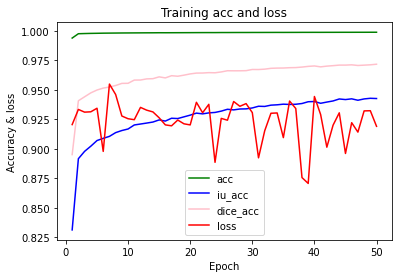

In [8]:
# training accuracy and loss plot
import matplotlib.pyplot as plt
plt.plot(epochs, acc, color='green', label='Training accuracy')
plt.plot(epochs, iu_acc, color='blue', label='Training iu_accuracy')
plt.plot(epochs, dice_acc, color='pink', label='Training dice_accuracy')
plt.plot(epochs, loss, color='red', label='loss')
plt.title('Training acc and loss')
plt.ylabel('Accuracy & loss')
plt.xlabel('Epoch')
plt.legend(['acc', 'iu_acc', 'dice_acc','loss'], loc='best')

plt.savefig("D:/Anil/saved_model/UNet/Training_acc_loss_pretrained_UNet_50epochs_10000_it.png", bbox_inches="tight", pad_inches=2)
plt.show()


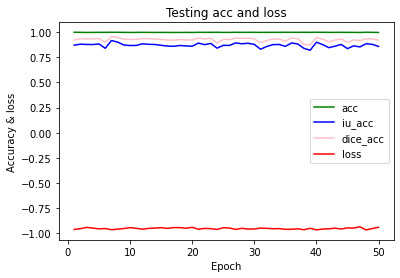

In [9]:
# training accuracy and loss plot
plt.plot(epochs, val_acc, color='green', label='Testing accuracy')
plt.plot(epochs, val_iu_acc, color='blue', label='Testing iu_accuracy')
plt.plot(epochs, val_dice_acc, color='pink', label='Testing dice_accuracy')
plt.plot(epochs, val_loss, color='red', label='Testing loss')
plt.title('Testing acc and loss')
plt.ylabel('Accuracy & loss')
plt.xlabel('Epoch')
plt.legend(['acc', 'iu_acc', 'dice_acc','loss'], loc='best')

plt.savefig("D:/Anil/saved_model/UNet/Testing_acc_loss_pretrained_UNet_50epochs_10000_it.png", bbox_inches="tight", pad_inches=2)
plt.show()


In [34]:
# model evaluation
model = get_unet(path_weight)


In [57]:
import cv2
import os
import numpy as np
dim = (512,512)
# path_test = 'D:/Dataset/Gray_mold/Unet_data/Preprocessed/test/'
testimg = np.zeros([1,512,512,3], dtype='uint8')
# img = cv2.imread(("D:/Anil/Dataset/gray_mold/test/img/img_110.png"),1)
img = cv2.imread(("D:/Anil/Dataset/gray_mold/test/img/img_109.png"),1)
img = cv2.resize(img,(512,512),interpolation = cv2.INTER_AREA)
b,g,r = cv2.split(img)
test_img = cv2.merge([r,g,b])
# img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
                  
# img = cv2.imread(os.path.join(path_test, 'img/', 'img_'+np.str(50) + '.png'),1)
# b,g,r = cv2.split(img)
# img = cv2.merge([r,g,b])
# cv2.imshow('original image',img)
# cv2.imshow('blue',b)
# cv2.imshow('green',g)
# cv2.imshow('red',r)
# cv2.imshow('merg image',merg_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
norm_img = test_img/255.0
testimg = np.reshape(norm_img,(1,512,512,3))
testimg.shape

(1, 512, 512, 3)

In [58]:
#%% predict 
# model = get_unet(weight_path)
# test_data = test_data()
y_pred = model.predict(testimg, verbose=1)


1/1 [==============================] - 0s 35ms/step


In [59]:
y_pred = np.reshape(y_pred,(512,512,1))
y_pred.shape

(512, 512, 1)

In [60]:
y_pred = y_pred*255

if cv2.waitKey(1) & 0xFF == ord('q'):
    cv2.destroyAllWindows()
    
cv2.imshow("original image",img)
cv2.imshow('predicted image',y_pred)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
#saving the model
filepath="E:/Dataset/Gray_mold/Unet_data/model_Unet_10epochs.hdf5"
model.save(filepath)


In [ ]:
weight_path = "E:/Dataset/Gray_mold/Unet_data/model_weight_Unet_10epochs.h5"
model.save_weights(weight_path)


In [ ]:
cv2.imwrite("D:/Dataset/Gray_mold/test_sample_x.png", y_pred)